In [22]:
import numpy as np        
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("MLP IC github")

from src.mnist import load_mnist_data # Pegar todos os dados dos digitos MNIST como binário, e transformar para np.array
from src.iris import load_iris_data # Pegar todos os dados dos digitos MNIST como binário, e transformar para np.array
from src.Model import Model # Classe custom Modelo Deep
from PIL import Image   # Manipulação de Pixels

!pip install --upgrade pip
!pip install requests

# Desvendando PCA com Numpy no dataset MNIST
#### Tecnica de recução de dimensionalidade, ou melhor, apenas mudança de base, redução de dimensionalidade é opcional.
# Seja X a nossa matriz inputs, para aplicar PCA devemos centralizar cada uma das 784 dimensões para zero. 
### Por exemplo, para o eixo *pixel_1*, temos 70000 imagens que tem valores descritos pelo eixo pixel_1 
###  Exemplo: (tome X[0] como a primeira imagem, ex: X[0][pixel_1] = 255, X[1][pixel_1]150, X[2][pixel_1] 0)
## $E[pixel_1] = \frac{255 + 150 + 0}{3} = 135$
### então subtraimos 135 das 3 imagem nesse exemplo para obter $E[pixel_1] = 0$
### X[0][pixel_1] = 255-135 = **120**,
### X[1][pixel_1]150-135 = **15**
### X[2][pixel_1] = **-135**


# Verificando Ortogonalidade entre **eixos** de componentes principais
### Dada uma matriz simétrica **$S_{n_{\times}n}$** , temos a garantia de ter **n** autovalores  reais, e considerando isso, podemos garantir que seus autovetores serão ortogonais:
### Tome $x$ e $y$ como autovetores vindos de distintos autovalores de S
## $Sx =\lambda_{1}x$
## $Sy =\lambda_{2}y$

### Temos que dada uma matriz simétrica, x e y são orthogonais, pois:
## $y^TSx =y^T\lambda_{1}x$ (i)
## $x^TSy =x^T\lambda_{2}y$ (ii)
Aplicamos transposta dos dois lados da equação ii.
## ii: $(x^TSy)^T =(\lambda_{2}x^Ty)^T$ 
Pela propriedades da transposta
## ii: $(Sy)^T(x^T)^T =(\lambda_{2}x^Ty)^T$
## ii: $y^TS^Tx =(\lambda_{2}x^Ty)^T$, como S é simetrica $\therefore S^T = S$
## ii: $y^TSx =\lambda_{2}(y^Tx)$, note que podemos $\lambda_{2}\neq\lambda_{1}$ porque S é simétrica, são autovalores distintos

### Somando (i) com -(ii)
## $y^TSx - y^TSx =y^T\lambda_{1}x -\lambda_{2}(y^Tx)$
*já que $\lambda_{1} - \lambda_{2}\neq 0$*
## $ 0 =(\lambda_{1} - \lambda_{2}) y^T x $   $\rightarrow y^T x = 0 $ 
#### Portanto seja quaisquer vetores y e x que possa ser transformada pela matrix simétrica **S**, seu produto interno é 0, e portanto são orthogonais





In [23]:

# traning_data, foi os 42 mil usados pelo modelo.
# dimensions, as dimensões usadas para treinamentodo modelo (784,128,128,10)
all_data = load_mnist_data()

print("Quantidade de exemplos:",	len(all_data["inputs"]))
print("Dimensão da imagem: ",		len(all_data["inputs"][0]))
print("Quantidade de digitos: ",	len(all_data["outputs"][0]))



Quantidade de exemplos: 70000
Dimensão da imagem:  784
Quantidade de digitos:  10



#  Voltando ao caso do MNIST, fazemos isso para os 70 mil exemplo de cada pixel e obtemos:
## $k = 70000$
### $E[pixel_i] = 0$, tal que $ i = 1,2 ... 784$
### A Covariancia entre dois eixos $pixel_n$ e $pixel_m$ e dado por: 
### $\sigma_{pixel_n*pixel_m} = \frac{\displaystyle\sum_{i=1}^{k}(pixel_n - E[pixel_n])(pixel_m - E[pixel_m])} {k}$
### Como $E[pixel_m]) = 0$ e $E[pixel_n]) = 0$, temos:
### $\sigma_{pixel_n*pixel_m} = \frac{\displaystyle\sum_{i=1}^{k}(pixel_n - 0)(pixel_m - 0)} {k}$
### que é o mesmo que o produto interno entre $pixel_n$ e $pixel_m$, ou em como multiplicação de matrizes fica:
### $(pixel_n)^T  pixel_m$



### Se temos **X** como matriz de imagens, então se fizermos o produto de matriz entre **X** e **$X^T$** teremos uma matriz de Covariancias,
### onde há todas combinações possiveis dentre os eixos de $pixel_i$ $i=1,...784$, e na diagonal dessa matriz teremos $COV[pixel_i, pixel_i]$, ou seja a variancia dos eixos $pixel_i$, e portanto sempre positivas.
##    $\begin{bmatrix}COV[pixel_1, pixel_1] & & \\ & \ddots & \\ & & COV[pixel_{784}, pixel_{784}]\end{bmatrix}$
## =  $\begin{bmatrix}(pixel_1)^T pixel_1 & & \\ & \ddots & \\ & & (pixel_{784})^T pixel_{784}\end{bmatrix}$ 

#### Podemos vizualiar essa matriz, e note quando plotarmos essa matriz em sua diagonal será branco, porque cov(x,x) sempre será positivo

In [24]:
class DimReducer:
	def __init__(self,data):
		self.X = data
		
		self.mean = np.ones(1)
		self.cov = np.ones(1)

		self.evalues = np.ones(1)
		self.evectors = np.ones(1)
		
		self.__normalize()
		self.__decompose()
		
	def __normalize(self):
		# Mean centering
		self.mean = np.mean(self.X, axis=0)
		self.std_dev = np.std(self.X, axis=0)
		print(f"{self.std_dev.shape=}")
		self.X = (self.X - self.mean)#*(np.ones(self.std_dev.shape)/self.std_dev)
		
		print(f"{self.mean.shape=}")

		# covariance, function needs samples as columns
		# cov = np.cov(X.T)
		self.cov = np.cov(X.T)
		print(f"{self.cov.shape=}")
		return self.X
		
	
	def __decompose(self):
		evalues, evectors = np.linalg.eig(self.cov)
		evectors = evectors.T
		print(f"{evalues.shape=}")
		print(f"{evectors.shape=}")
		# -> eigenvector v = [:,i] column vector, transpose for easier calculations
		# sort eigenvectors
		indexes = np.argsort(evalues)[::-1]
		evalues = evalues[indexes]
		evectors = evectors[indexes]
		
		self.evalues  = evalues
		self.evectors = evectors
		return evalues, evectors

	def change_basis(self,data, num_components:int):
		self.num_components = num_components
		# project data
		# X = X - self.mean
		X_transformed = np.dot(self.X, self.evectors[0 : num_components].T)
		return X_transformed

	def invert_basis(self, data_transformed):

		X_reconstructed = np.dot(self.evectors[0 : self.num_components].T, data_transformed.T).T
		print(f"{X_reconstructed.shape=}")
		return X_reconstructed



## Classe Dimension Reducer
### $X =  X - \bar{X}$, onde $\bar{X}$ é uma matriz 784x1 de medias de cada linha do X
### $COV = X^TX$ , Onde $X \epsilon$ $ℝ^{7000\times784}$, e COV $\epsilon$ $ℝ^{784\times784}$, quadratica e simétrica
#### Como COV é simétrica, sabemos que essa pode ser decomposta em Autovetores e Autovalores
#### as colunas de Q são autovetores
Perceba que como COV  é simetrica, ela tem autovetores ortogonais, e 784 autovalores. 
### $COV \cdotp Q = Q \Lambda $, onde $\Lambda $ é uma matriz diagonal com os auvalores de COV, e Q são autovetores ortogonais ($Q^{-1} = Q^T$) então:
### $COV \cdotp QQ^{-1} = Q \Lambda Q^{-1}$
### $COV = Q \Lambda Q^{T}$

### Pelo Teorema Spectral, toda matriz pode ser ser decomposta em matriz de rotação, seguinda de escalonamento, seguida de outra rotação, então vemos aqui que $\Lambda$ é a matriz de escalonamento da matriz de Covariacias e portanto:
- Projeçoes de **X** em *autovetores* de COV que contém maior variancia está atrelado a autovalor de maior magnitude
- Os autovetores de COV podem servir como eixos para nova coordenada, pois são linearmente independentes e, melhor ainda, ortogonais
- A matriz Q pode poder servir como Tranformação Linear para nova base, e pode ser facilmente revertivel, pois $Q^{-1}=Q^T$




## Função para auxiliar na vizualização de Matrizes de Covariancia

In [25]:
def plot_matrix(matrix:np.ndarray, dim=(28,28),figsize=(6,6)):
	plt.figure(figsize=figsize)
	plt.gray()
	#plt.imshow( example.reshape((28, 28)),cmap='binary_r', interpolation='nearest',clim=(-50, 255))
	plt.imshow(matrix.reshape(dim),interpolation="none")
	plt.xticks([])
	plt.yticks([])
	plt.show()

## Observe a Covariancia de X original

### Podemos ver visualmente que é *Simétrica* e que na diagmosal é mais positiva que cada dimensão $pixel_i$ existe alta correlação com outros eixos $pixel_m$ {$n,m = 1,2...784$}

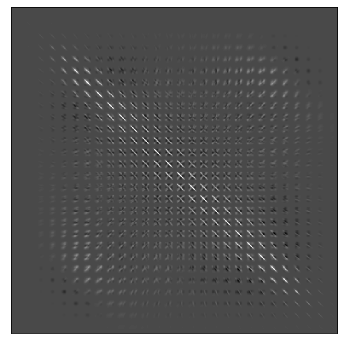

In [26]:
X = all_data["inputs"]
plot_matrix(np.cov(X.T),dim=(784,784))



# Encontrando Dados Tranformados "$X_{transformado}$", onde sua matriz Covariancia seja diagonal
### Tome $X_{transformado}= \hat{X} =  X \cdotp Q^T $, Q $\epsilon$ $ℝ^{784 \times 784}$   $X^T$ $\epsilon$ $ℝ^{784 \times k}$
### $COV_{\hat{X}} = \frac{1}{k} (X \cdotp Q^T)^T X \cdotp Q^T$
### $COV_{\hat{X}} = \frac{1}{k} Q X^T XQ^T$
### $COV_{\hat{X}} = \frac{1}{k} Q (X^T X) Q^T$, tal que $X^TX = Q \Lambda Q^T = Q^T \Lambda Q $
### $COV_{\hat{X}} = \frac{1}{k} Q (Q^T \Lambda Q) Q^T$ , tal que $Q^T = Q^{-1}$ 
### $COV_{\hat{X}} = \frac{1}{k} Q {-1} \Lambda Q Q^{-1}$
### $COV_{\hat{X}} = \frac{1}{k} I \Lambda I = \frac{1}{k} \Lambda $
#### Portanto com nossos dados tranformados, temos Matriz de Covariancia Diagonal, o que significa que os eixos desses dados são **estatisticamente independentes**.
#### Agora, $X_{transformado}$ está em uma base que tem *minima redundância* entre suas variaveis, e seus eixos são compostos pelos autovetores da Matriz **COV**  do **X** original

## Obeserve agora com nossos dados transformado vamos uma Matriz Covariancia diagonal 
#### Ainda sem diminuir as dimensões, ou seja kx784
#### Veja que toda variação de encontra na diagonal, e ainda estão concentrados no canto superior direito
#### Ou seja, são poucos **componentes principais** que seguram maior parte da variância

self.std_dev.shape=(784,)
self.mean.shape=(784,)
self.cov.shape=(784, 784)
evalues.shape=(784,)
evectors.shape=(784, 784)


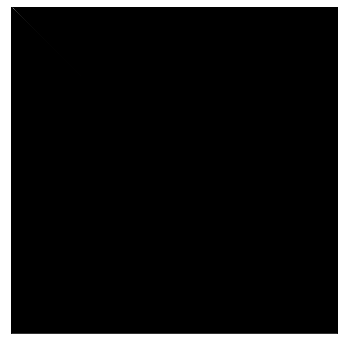

Shape de X: (70000, 784)
Shape de X_transformed: (70000, 784)


' Note que praticamente não da pra ver a parte branca que representa a variância na diagonal da matriz de covariância'

In [27]:

# Project the data onto the 2 primary principal components
pca = DimReducer(X)

X_transformed = pca.change_basis(X,num_components= 784)

plot_matrix(np.cov(X_transformed.T),dim=(784,784))

print("Shape de X:", X.shape)
print("Shape de X_transformed:", X_transformed.shape)
""" Note que praticamente não da pra ver a parte branca que representa a variância na diagonal da matriz de covariância"""


## Com **50** Componentes principais:
### podemos observa a Matriz Cov dos dados transformados e percebendo que toda da variancia é concentrada na diagonal e 82% nos primeiros 50 autovetores

### Podemos observar o valor acumulativo quantidade de informação dos componentes principais no plot acumulativo das autovalores abaixo:
### Basicamente é a visualização de $COV_{\hat{X}}$ que é $\Lambda$ de $X^T\cdot X$ original

Variancia correponde há 50 PC's: 0.8285873791091132
Shape do novo X_transformed: (70000, 50)


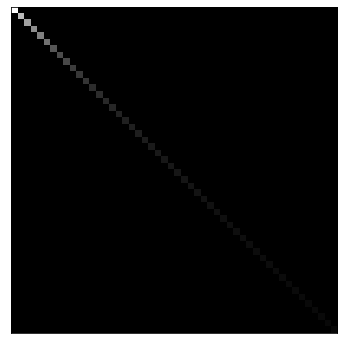

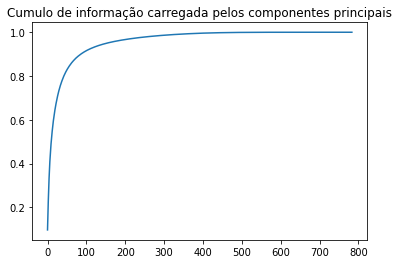

In [28]:
componentes_qntd = 50
print(f"Variancia correponde há {componentes_qntd} PC's:", np.cumsum(pca.evalues)[componentes_qntd]/np.sum(pca.evalues))

X_transformed = pca.change_basis(X,num_components= componentes_qntd)

print("Shape do novo X_transformed:", X_transformed.shape)
plot_matrix(np.cov(X_transformed.T),dim=(componentes_qntd,componentes_qntd))

# Com 50 PC's temos 82% e com 784 assintota 100% de informação, como é esperado
plt.title("Cumulo de informação carregada pelos componentes principais")
plt.plot(np.cumsum(pca.evalues)/np.sum(pca.evalues))


### A reconstrução de $\hat{X}$ a partir de *50 PC's* mantém bem parecida a distribuição de covariação da matriz de covariancia inicial ($COV_{X}$) 

X_reconstructed.shape=(70000, 784)


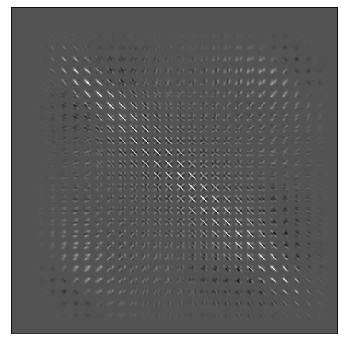

Shape of X_reconstructed: (70000, 784)


In [29]:
X_reconstructed = pca.invert_basis(X_transformed)

plot_matrix(np.cov(X_reconstructed.T),dim=(784,784))
print("Shape of X_reconstructed:", X_reconstructed.shape)

## Podemos observar a distribuição dos numeros utilizando 2 dimensões e 3 dimensões, ou seja 2 e 3 componentes principais

### $\implies$ MUDE os **pcs_indices**
#### Perceba: os pcs **0-1** as projeções dos dados ficam mais bem distribuidos (maior variancia) e **48-49**, menor variancia

Variancia correponde há 2 PC's: 0.23051091490096473
pc1.shape=(70000,)
pc2.shape=(70000,)
colors.shape=(70000,)


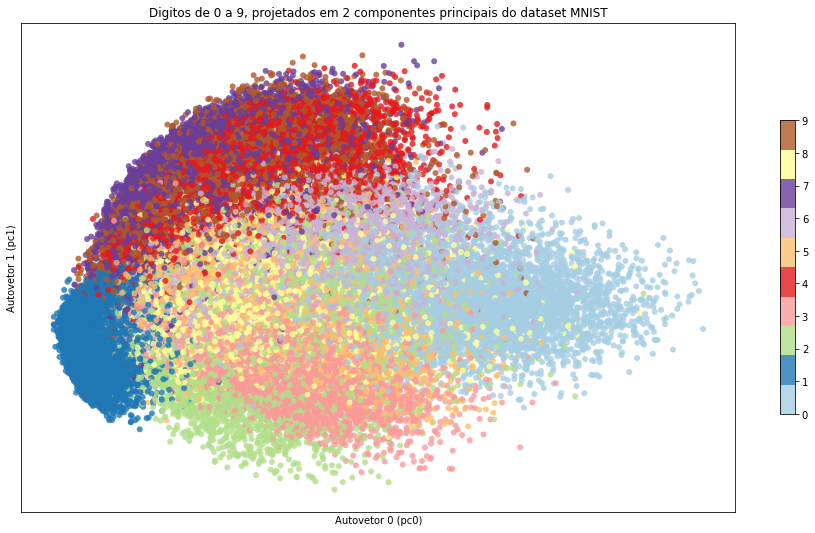

In [30]:
pcs_indices = [0,1,2]
#pcs_indices = [48,49,2]

print(f"Variancia correponde há {2} PC's:", np.cumsum(pca.evalues)[2]/np.sum(pca.evalues))

pc1 = X_transformed[:, pcs_indices[0]]
pc2 = X_transformed[:, pcs_indices[1]]
pc3 = X_transformed[:, pcs_indices[2]]

colors = np.array([list(y).index(1) for y  in all_data["outputs"]])

print(f"{pc1.shape=}")
print(f"{pc2.shape=}")
print(f"{colors.shape=}")


plt.figure(figsize=(16,9))

plt.scatter(
   	pc1, pc2, c=colors, edgecolor="none", alpha=0.8, 
		#cmap=plt.cm.get_cmap("RdGy_r", 10)
		#cmap=plt.cm.get_cmap("rainbow", 10)
		cmap=plt.cm.get_cmap("Paired", 10)
	)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Autovetor {pcs_indices[0]} (pc{pcs_indices[0]})")
plt.ylabel(f"Autovetor {pcs_indices[1]} (pc{pcs_indices[1]})")
plt.title("Digitos de 0 a 9, projetados em 2 componentes principais do dataset MNIST")
plt.colorbar(shrink = 0.6)
plt.show()



Variancia correponde há 3 PC's: 0.28454476018644703


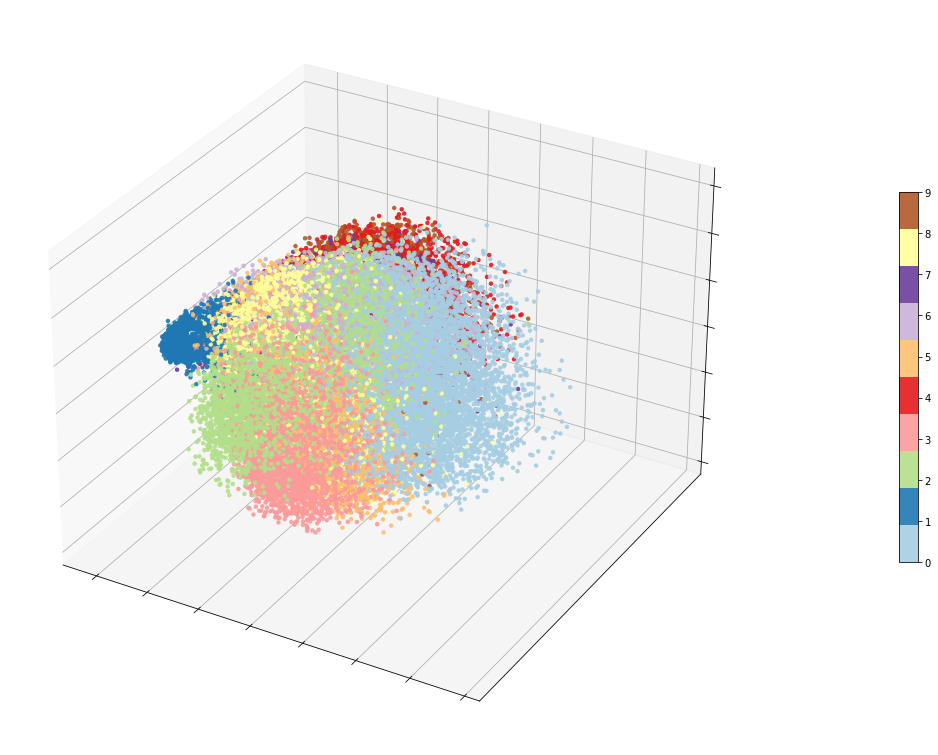

In [31]:
print(f"Variancia correponde há {3} PC's:", np.cumsum(pca.evalues)[3]/np.sum(pca.evalues))

# Create the figure
fig = plt.figure(figsize=(54,30))
ax = fig.add_subplot(211,projection='3d')

# Plot the values
scatterplot = ax.scatter(
   	pc1, pc2, pc3, c=colors, edgecolor="none", alpha=0.9, 
		cmap=plt.cm.get_cmap("Paired", 10)
		#cmap=plt.cm.rainbow
		#cmap=plt.cm.RdGy_r
	)
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
#ax.set_zlabel('Z-axis')
fig.colorbar(scatterplot,shrink = 0.5)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.zaxis.set_major_formatter(plt.NullFormatter())
plt.show()

## Reconstrução do Digito
### Podemos também observar visualmente quanto de informação é possivel recuperar de acordo com a quantidade de número de componentes principais (PC's) que escolhermos
#### TROQUE **componentes_qntd** para manter mais ou menos informação
#### TROQUE **indices_digito** para mudar o digito mostrado

Note: Se deixar componentes_qntd abaixo de **4**, quase TODO numero parece um zero, pois deve ser as coisas mais comum entre um e outro


#### $\implies$ Mude componentes_qntd para **4**

X_reconstructed.shape=(70000, 784)


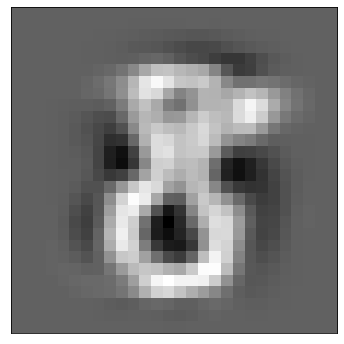

In [32]:
""" Troque a qntd de componentes e veja a reconstrução """
# PC's no intervalo [1,784]
componentes_qntd = 50
# Indices no intervalo [0,70'000)
indices_digito = 70000-9



X_transformed 		= pca.change_basis(X,num_components=componentes_qntd)
X_reconstructed 	= pca.invert_basis(X_transformed)
plot_matrix(X_reconstructed[indices_digito].reshape(28,28))

In [33]:
def indexes_from_label(label:int, data):
	indexes = list()
	for i,onehot in enumerate(data["outputs"]):
		if list(onehot).index(1) == label:
			indexes.append(i)
	return indexes

#print(indexes_from_label(2, all_data))

# Treinamento
## Agora partimos para o treinamento do modelo com dimensão reduzida
Vamos procurar PC's que nos deem aproximadamente 95%  da informação retida.

In [34]:
# Vamos escolher um power
n_components_trainning = 200
split = 60000

pca_train = DimReducer(all_data["inputs"])
reduced_data = pca_train.change_basis(all_data["inputs"],n_components_trainning)

normalize_term = np.amax(reduced_data)

print("Normalizing Term:",	normalize_term)
print(f"Variancia correponde há {n_components_trainning} PC's:", np.cumsum(pca.evalues)[n_components_trainning-1]/np.sum(pca.evalues))

self.std_dev.shape=(784,)
self.mean.shape=(784,)
self.cov.shape=(784, 784)
evalues.shape=(784,)
evectors.shape=(784, 784)
Normalizing Term: 2383.983577237037
Variancia correponde há 200 PC's: 0.9665395399044862


In [35]:

# Treinamos com 60 mil exemplos
train_data = {
	"inputs" :	reduced_data[:split]/normalize_term,
	"outputs":	all_data["outputs"][:split]
}

# Restante dos 10 mil exemplos que o modelo não viu, será nossos dados de teste
test_data = {
	"inputs" :	reduced_data[split:]/normalize_term,
	"outputs":	all_data["outputs"][split:]
}

print(F"{train_data['inputs'].shape=}")
print(F"{train_data['outputs'].shape=}")
print(f"Std Dev : {np.std(train_data['inputs'][0])=}")

print(F"{test_data['inputs'].shape=}")
print(F"{test_data['outputs'].shape=}")

train_data['inputs'].shape=(60000, 200)
train_data['outputs'].shape=(60000, 10)
Std Dev : np.std(train_data['inputs'][0])=0.05175051710993825
test_data['inputs'].shape=(10000, 200)
test_data['outputs'].shape=(10000, 10)


## Treinando Modelo

- 200 dimensões input
- 3 hidden_layers de 256 dimensões
- 0.025 lr

In [36]:
# Modelo com configurações mencionada anteriormente

model_filename = "pca_model_300_3x256_0.9836" # Acurácia:0.9842 -> 0.9836 -> 0.9832 

# model  = Model((n_components_trainning,256,256,256,10), activation="sigmoid", verbose=0, wr=(-.55,.55)) 
"""Caso queira começar do zero, comente a proxima linha e descomente a linha anterior"""
model  = Model.load("./models/" + model_filename)

print(train_data["inputs"].shape)
print(train_data["outputs"].shape)


(60000, 200)
(60000, 10)


In [37]:
"""É possivel repetir essa celula diversas vezes para treinar o modelo, com epochs, our learning rate diferentes"""
learning_rate = 0.001

epochs = 0

print("\n> Model Started Training...\n")
			
model.train(
	train_data["inputs"],
	train_data["outputs"],
	lr = learning_rate, epochs=epochs,
	shuffle=True,
	autosave=False)
	
# Caso já tenha um modelo salvo, dê load assim
#model = Model.load("./models/" + model_filename)

print("> Done.")




> Model Started Training...

> Done.


/*==================================================*/
X  (input) layer:
[[-7.27032777e-02 -9.93521963e-03  2.35031332e-01 -5.91130617e-02
   8.14999914e-02 -9.94772296e-02 -1.93250811e-01  6.54051052e-02
   3.33910006e-02  5.77759566e-02  4.86423485e-02  2.08771380e-01
   9.06933888e-02 -1.21928021e-01 -7.46638094e-02  5.09804621e-02
   1.12604978e-01 -1.08880921e-01  4.39776232e-02  8.67189630e-02
  -1.77903911e-01  7.88967768e-02  5.29344567e-02 -6.27690892e-02
  -2.68748227e-02  8.02697634e-02  5.57036996e-02  8.42910826e-02
  -1.43958843e-02 -1.63268808e-02  2.43926736e-02  8.50773581e-02
  -1.35762107e-01  4.71221590e-02  7.37199881e-02  1.59126636e-02
   1.09248500e-02  3.82299648e-02  4.69743787e-03  5.82917687e-02
  -9.55688321e-03  1.35465324e-02  3.26692338e-02  2.39379887e-02
   3.75479427e-02  8.59029645e-02 -1.08391474e-02 -3.92479722e-02
   8.27402514e-02  3.29493328e-03  7.44681099e-03 -7.64264442e-03
  -6.86160319e-02  3.85215860e-02 -3.18386352e-02 -8.43331130e-02
   

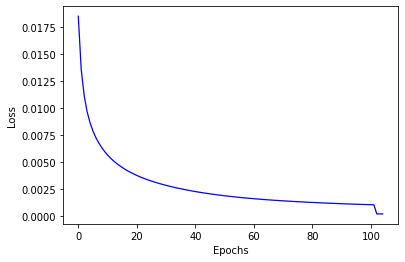

> model saved in:  ./models/pca_model_300_3x256_0.9836


In [38]:
""" Seeing Stats And Saving Model"""

model.print(verbose=0)

model.save("./models/" + model_filename)
#model.save("test_model",compact=True)

### Função usada para fazer predições do set MNIST com o Modelo. 
*Ao usar **test_prediction** ira mostrar a **imagem**, o **label** correto, e a **decisão** do modelo*

In [39]:
def test_prediction(index, reducted_data, reconstructed_data, model:Model):
	current_image = reducted_data["inputs"][index]
	y_predict = model.predict(current_image)[0]
	prediction = (y_predict == y_predict.max()).astype(int)

	guess = list(prediction).index(1)
	
	label = reducted_data["outputs"][index]
	ground_truth = list(label).index(1)

	# Opção de desobrigar de fornecer label correto, para quando formor utilizar paint
	if len(label) < 10:
		label = "made on paint"
		ground_truth = " paint"

	print("Label: ", label)
	print("Prediction: ", prediction)
	
	current_image = reconstructed_data["inputs"][index]

	plt.gray()
	plt.title("Model thinks it is: " + str(guess) + "\nGround truth: " + str(ground_truth))
	plt.imshow( current_image.reshape((28, 28)) * 255, interpolation='nearest')
	plt.xticks([])
	plt.yticks([0])
	plt.show()

#### Função p/ testar a acurácia dos restante 10 mil digitos que o modelo não viu ainda
##### e ainda retorna todos os indices errados

In [40]:
def get_acurracy(testing_data):
	
	predicts = list()
	for y in testing_data["inputs"]:
		y_predict = model.predict(y)[0]
		prediction = (y_predict == y_predict.max()).astype(int)
		predicts.append(prediction)
	return model.accuracy(predictions=predicts, outputs=testing_data["outputs"], verbose=0)


### Array de indices onde o modelo errou
##### Acurácia: cerca de **98.3%** usando 10 mil exemplos dos dados de teste os quais o modelo nunca viu

In [41]:
accuracy,wrong_indexes = get_acurracy(test_data)

print( "Qntd de exemplos:",len(test_data["inputs"]))
# print(f"Indexes onde está errado: {wrong_indexes}\n")
print("Acurácia: ",accuracy,'\n' )

Qntd de exemplos: 10000
Acurácia:  0.9833 



### Escolha um index no intervalo [0,10'000)
#### *A ideia é poder ver a imagem e a predição do modelo*

X_reconstructed.shape=(10000, 784)
Label:  [0 0 0 1 0 0 0 0 0 0]
Prediction:  [0 0 0 1 0 0 0 0 0 0]


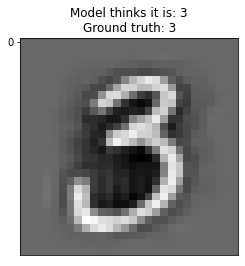

Reconstuido


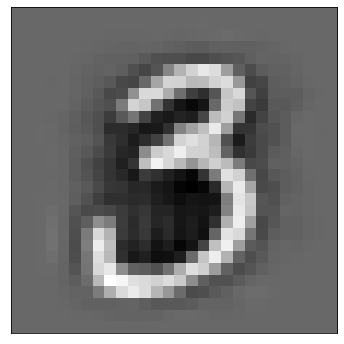

Original


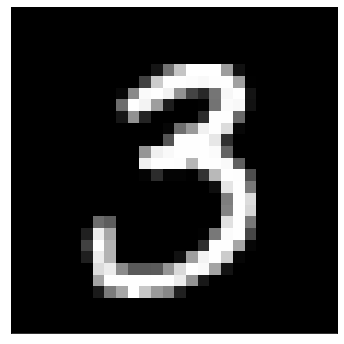

In [43]:
# Escolha um index no intervalo [0,10'000) Cerca de 98% vai estar certo
test_data_reconstructed = {
	"inputs": pca_train.invert_basis(test_data["inputs"]),
	"outputs": test_data["outputs"]
} 

index = 90

test_prediction(index,test_data,test_data_reconstructed,model)
print("Reconstuido")
plot_matrix(test_data_reconstructed["inputs"][index])
print("Original")
plot_matrix(all_data["inputs"][split:][index])